In [46]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-1d71bac5-a341-449f-9ca7-b29de95e771a',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': 'ejujKveBRS3Bk7l3pzjemEQDhTSaOKmqCg6x6osXWkx4'
}

configuration_name = 'os_2d970470a6354234a1716fe9f4db519b_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('US_Accidents_Dec19.csv', 'bdppproject-donotdelete-pr-nejualq57kuqe4'))


# Imports

In [2]:
from pyspark.sql.functions import when, count, col, isnan, countDistinct,from_unixtime,from_utc_timestamp, unix_timestamp,split
import seaborn as sns 
import matplotlib.pyplot as plt 

# Define variables

In [51]:
# Define data information

# Label
colLabel = ["Severity"]
# Categorical values
colCat = ['TMC',
        'Street',
        'Side',
        'City',
        'County',
        'State',
        'Zipcode',
        'Country',
        'Airport_Code',
        'Wind_Direction',
        'Weather_Condition',
        'Amenity',
        'Bump',
        'Crossing',
        'Give_Way',
        'Junction',
        'No_Exit',
        'Railway',
        'Roundabout',
        'Station',
        'Stop',
        'Traffic_Calming',
        'Traffic_Signal',
        'Turning_Loop',
        'Sunrise_Sunset',
        'Civil_Twilight',
        'Nautical_Twilight',
        'Astronomical_Twilight',
]

# Removable columns (Since we dont have the tools for it at the moment, example: Text analysis)
colRem = ['ID', 'Source','End_Time', 'End_Lat', 'End_Lng', 'Description','Timezone']

# Numerical values
colNum = list(filter(lambda x: x not in colLabel and x not in colCat and x not in colRem , df.columns))

# 1. Analysis

In [45]:
print(f"Categories:\n \
Labels: {len(colLabel)}\n \
Classes: {len(colCat)}\n \
Removed: {len(colRem)}\n \
Numerical: {len(colNum)}") 

print(f"Rows: {df.count()}\nColumns {len(df.columns)}")
df.printSchema()
df.take(1)

Categories:
 Labels: 1
 Classes: 29
 Removed: 6
 Numerical: 13
Rows: 2974335
Columns 49
root
 |-- TMC: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): string (nullable = true)
 |-- Wind_Chill(F): string (nullable = true)
 |-- Humidity(%): string (nullable = true)
 |-- Pressure(in): string (nullable = true)
 |-- Visibility(mi): string (nullable = true)
 |-- W

[Row(TMC='201.0', Severity='3', Start_Time='2016-02-08 05:46:00', Start_Lat='39.865147', Start_Lng='-84.058723', Distance(mi)='0.01', Number=None, Street='I-70 E', Side='R', City='Dayton', County='Montgomery', State='OH', Zipcode='45424', Country='US', Timezone='US/Eastern', Airport_Code='KFFO', Weather_Timestamp='2016-02-08 05:58:00', Temperature(F)='36.9', Wind_Chill(F)=None, Humidity(%)='91.0', Pressure(in)='29.68', Visibility(mi)='10.0', Wind_Direction='Calm', Wind_Speed(mph)=None, Precipitation(in)='0.02', Weather_Condition='Light Rain', Amenity='False', Bump='False', Crossing='False', Give_Way='False', Junction='False', No_Exit='False', Railway='False', Roundabout='False', Station='False', Stop='False', Traffic_Calming='False', Traffic_Signal='False', Turning_Loop='False', Sunrise_Sunset='Night', Civil_Twilight='Night', Nautical_Twilight='Night', Astronomical_Twilight='Night')]

## Get missing data

In [5]:
# Check data

df_missingVals_colNum = df.select([count(when(col(c).isNull(), c)).alias(c) for c in colNum])
df_missingVals_colCat = df.select([count(when(col(c).isNull(), c)).alias(c) for c in colCat])

#df_missingVals_colNum_proc = df.select([(count(when(col(c).isNull(), c))/count(c)).alias(c) for c in colNum])
#df_missingVals_colCat_proc = df.select([(count(when(col(c).isNull(), c))/count(c)).alias(c) for c in colCat])

# Missing value in each column
df_missingVals_colCat.collect()
df_missingVals_colNum.collect()

[Row(Start_Time=0, Start_Lat=0, Start_Lng=0, Distance(mi)=0, Number=1917605, Weather_Timestamp=36705, Temperature(F)=56063, Wind_Chill(F)=1852623, Humidity(%)=59173, Pressure(in)=48142, Visibility(mi)=65691, Wind_Speed(mph)=440840, Precipitation(in)=1998358)]

In [8]:
df_missingVals_colNum.groupBy()

rdd = sc.parallelize(df_missingVals_colNum.collect())
rdd.first()
#rdd.filter(lambda x: x > 10000).first()
#rdd.filter(lambda c: int(c) > 10000).collect()
# TODO: NOT WORKING



Row(Start_Time=0, Start_Lat=0, Start_Lng=0, Distance(mi)=0, Number=1917605, Weather_Timestamp=36705, Temperature(F)=56063, Wind_Chill(F)=1852623, Humidity(%)=59173, Pressure(in)=48142, Visibility(mi)=65691, Wind_Speed(mph)=440840, Precipitation(in)=1998358)

In [9]:
# How many that is above 30%
missingLimit = df.count() - df.count()*0.3 

#df.select([when(count(when(col(c).isNull(), c)) > missingLimit, c).alias(c) for c in df.columns]).collect()[0].asDict()
#df.filter(lambda c: print(type(c)))
#df.where([when(count(when(col(c).isNull(), c)) > missingLimit, c).alias(c) for c in df.columns] != None).show()

df.agg(*[
    when(count(c) < missingLimit,c).alias(c)    # vertical (column-wise) operations in SQL ignore NULLs
    for c in df.columns
]).show()

+----+------+----+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+------+----+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|Source| TMC|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Number|Street|Side|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise

## Get categorical values

In [10]:
# Checking how many classes that can be used
df.agg(*(countDistinct(col(c)).alias(c) for c in colCat)).collect()[0].asDict()

{'TMC': 21,
 'Street': 160715,
 'Side': 3,
 'City': 11685,
 'County': 1713,
 'State': 49,
 'Zipcode': 377152,
 'Country': 1,
 'Timezone': 4,
 'Airport_Code': 1995,
 'Wind_Direction': 24,
 'Weather_Condition': 120,
 'Amenity': 2,
 'Bump': 2,
 'Crossing': 2,
 'Give_Way': 2,
 'Junction': 2,
 'No_Exit': 2,
 'Railway': 2,
 'Roundabout': 2,
 'Station': 2,
 'Stop': 2,
 'Traffic_Calming': 2,
 'Traffic_Signal': 2,
 'Turning_Loop': 1,
 'Sunrise_Sunset': 2,
 'Civil_Twilight': 2,
 'Nautical_Twilight': 2,
 'Astronomical_Twilight': 2}

## Causes

### Frequency of severity and state

In [11]:
state_freq = df.groupBy('State').count().orderBy('count',ascending=False).collect()

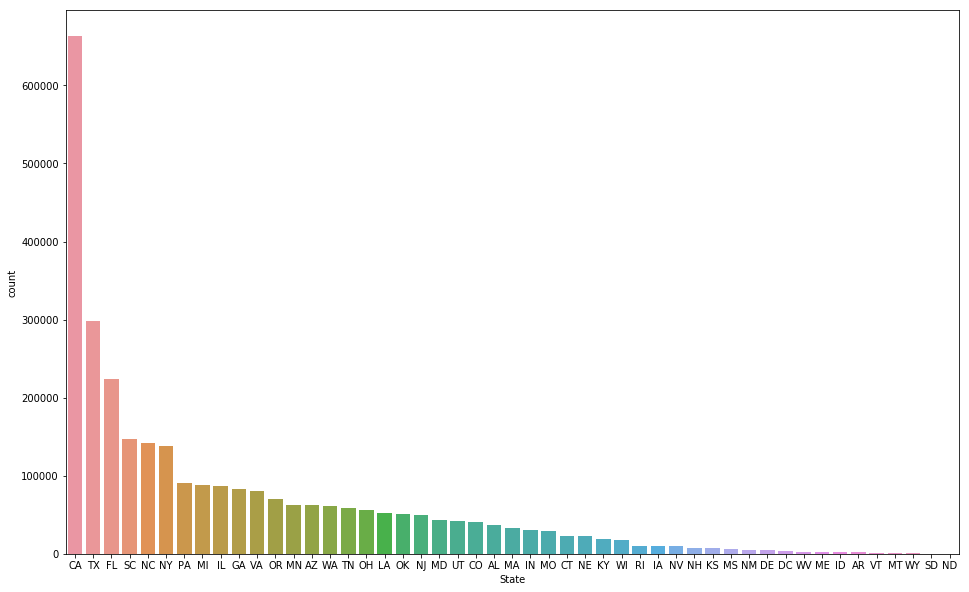

In [12]:
rdd = sc.parallelize(state_freq)
pd_states = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(pd_states['State'],pd_states['count'])

In [13]:
state_severity_freq = df.groupBy('State','Severity').count().orderBy('count',ascending=False).collect()


In [14]:
state_severity_freq

[Row(State='CA', Severity='2', count=445381),
 Row(State='TX', Severity='2', count=215027),
 Row(State='CA', Severity='3', count=211189),
 Row(State='FL', Severity='2', count=144622),
 Row(State='NC', Severity='2', count=121261),
 Row(State='SC', Severity='2', count=114339),
 Row(State='NY', Severity='2', count=82388),
 Row(State='TX', Severity='3', count=79467),
 Row(State='FL', Severity='3', count=71631),
 Row(State='PA', Severity='2', count=67778),
 Row(State='OR', Severity='2', count=61538),
 Row(State='IL', Severity='2', count=58901),
 Row(State='MI', Severity='2', count=52583),
 Row(State='NY', Severity='3', count=49968),
 Row(State='AZ', Severity='2', count=47248),
 Row(State='OK', Severity='2', count=46194),
 Row(State='VA', Severity='2', count=42556),
 Row(State='GA', Severity='3', count=42393),
 Row(State='LA', Severity='2', count=41674),
 Row(State='TN', Severity='2', count=38526),
 Row(State='WA', Severity='2', count=37528),
 Row(State='MN', Severity='2', count=37017),
 Row

In [23]:
#rdd = sc.parallelize(state_severity_freq)
#hurr = rdd.filter(lambda c: rdd['Severity'] == '1')

#pd_states = rdd.toDF().toPandas()


# 
# Plot data
#fig,ax = plt.subplots(figsize=(16,10))
#sns.barplot(pd_states['Severity'],pd_states['count'])
#sns.barplot(pd_states['State']=='2',pd_states['count'])
#sns.barplot(pd_states['State']=='3',pd_states['count'])
#sns.barplot(pd_states['State']=='4',pd_states['count'])

### Weather conditions

In [16]:
weather_freq = df.groupBy('Weather_Condition').count().orderBy('count',ascending=False).collect()

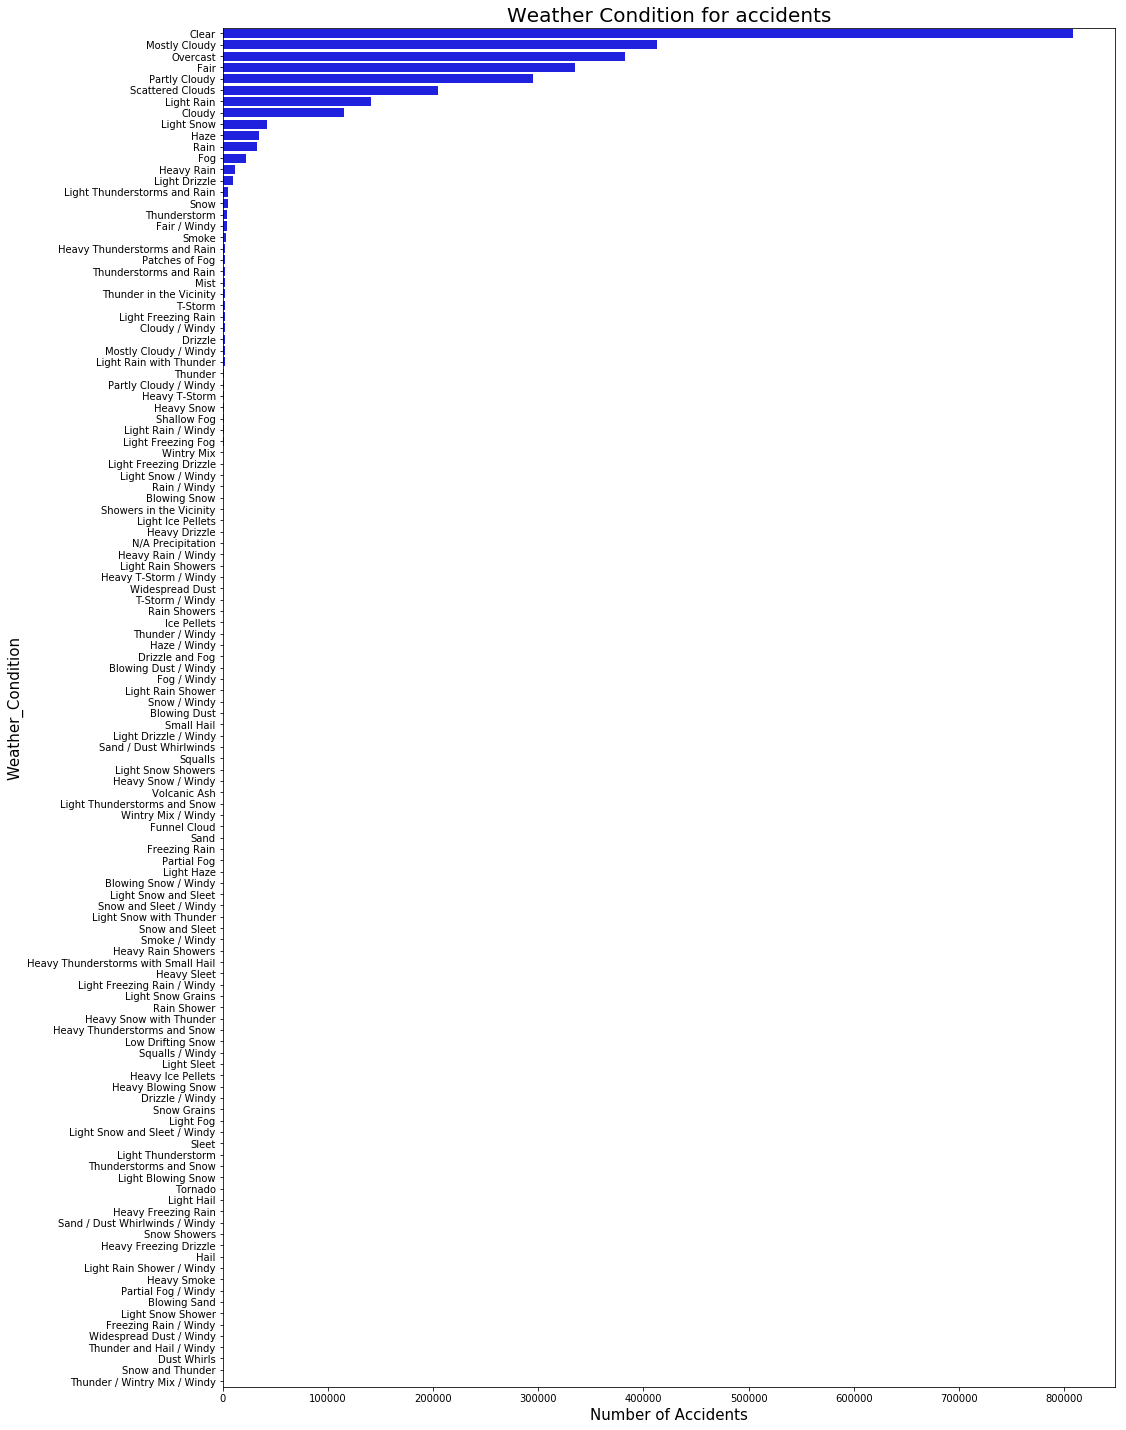

In [17]:
#display_limit = 12 # Limit on how many objects that should be displayed

fig, ax=plt.subplots(figsize=(16,25))

rdd = sc.parallelize(weather_freq)
pd_weather = rdd.toDF().toPandas()

b = sns.barplot(pd_weather['count'][:],pd_weather['Weather_Condition'][:], color="blue")

b.axes.set_title("Weather Condition for accidents",fontsize=20)
b.set_xlabel("Number of Accidents",fontsize=15)
b.set_ylabel("Weather_Condition",fontsize=15)
b.tick_params(labelsize=10)
plt.show()


In [18]:
# How severe was the condition for each type of weather?

### Time when accidents occured

### Development of accidents on year

# 2. Preprocessing

In [19]:
# Drop nan - Dont do this until cleaning above is fixed



# Drop features that is less than 0.01% chance
# Impute dataset
# Standarlize
# One-hot encoding

In [ ]:
# Todo Replace with existing data in table
# Start_Time,End_Time, Weather_Timestamp, Timezone 
# 2016-02-08 05:46:00
df.selectExpr("unix_timestamp(from_utc_timestamp(Start_Time, Timezone),'YYYY-MM-DD HH:MM:SS') as Start_Time",
              "unix_timestamp(from_utc_timestamp(End_Time, Timezone),'YYYY-MM-DD HH:MM:SS') as End_Time",
              "unix_timestamp(from_utc_timestamp(Weather_Timestamp, Timezone),'YYYY-MM-DD HH:MM:SS') as Weather_Timestamp",
             ).show()


In [52]:
# Drop missing values
# TODO check that it works
dfs= df
colRem.extend(['Number','Wind_Chill(F)','Precipitation(in)']) 

dfs = dfs.drop(*colRem)
dfs = dfs.drop()
#dfs.show(2)

['ID', 'Source', 'End_Time', 'End_Lat', 'End_Lng', 'Description', 'Number', 'Wind_Chill(F)', 'Precipitation(in)']
+-----+--------+-------------------+---------+----------+------------+--------------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-----------+------------+--------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  TMC|Severity|         Start_Time|Start_Lat| Start_Lng|Distance(mi)|              Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traff

In [55]:
print(df.count())
print(dfs.count())


2974335
2974335


In [82]:
# Convert from string to integer values
# TODO: Does not work since data contains Nan/Null?
df = df.select(
        col('TMC').cast('string'),
        col('Severity').cast('string'),
        col('Start_Time').cast('int'),
        col('Start_Lat').cast('float'),
        col('Start_Lng').cast('float'),
        col('Distance(mi)').cast('float'),
        col('Street').cast('string'),
        col('Side').cast('string'),
        col('City').cast('string'),
        col('County').cast('string'),
        col('State').cast('string'),
        col('Zipcode').cast('string'),
        col('Country').cast('string'),
        col('Timezone').cast('string'),
        col('Airport_Code').cast('string'),
        col('Weather_Timestamp').cast('int'),
        col('Temperature(F)').cast('float'),
        col('Wind_Chill(F)').cast('float'),
        col('Humidity(%)').cast('float'),
        col('Pressure(in)').cast('float'),
        col('Visibility(mi)').cast('float'),
        col('Wind_Direction').cast('float'),
        col('Wind_Speed(mph)').cast('float'),
        col('Weather_Condition').cast('string'),
        col('Amenity').cast('string'),
        col('Bump').cast('string'),
        col('Crossing').cast('string'),
        col('Give_Way').cast('string'),
        col('Junction').cast('string'),
        col('No_Exit').cast('string'),
        col('Railway').cast('string'),
        col('Roundabout').cast('string'),
        col('Station').cast('string'),
        col('Stop').cast('string'),
        col('Traffic_Calming').cast('string'),
        col('Traffic_Signal').cast('string'),
        col('Turning_Loop').cast('string'),
        col('Sunrise_Sunset').cast('string'),
        col('Civil_Twilight').cast('string'),
        col('Nautical_Twilight').cast('string'),
        col('Astronomical_Twilight').cast('string')
    ) 

In [83]:
# Impute 
# Probobly a bad Idea but why not?
from pyspark.ml.feature import Imputer
# Wind_Chill,Wind_Speed
imputer = Imputer(inputCols=['Wind_Chill(F)', 'Wind_Speed(mph)'], outputCols=['Wind_Chill(F)', 'Wind_Speed(mph)'])
imputer.setStrategy("median")
model = imputer.fit(df)
imputedHousing = model.transform(df)
imputedHousing.select("Wind_Chill(F)", "Wind_Speed(mph)").show(5)

+-------------+---------------+
|Wind_Chill(F)|Wind_Speed(mph)|
+-------------+---------------+
|         54.0|            7.0|
|         54.0|            7.0|
|         33.3|            3.5|
|         31.0|            4.6|
|         33.3|            3.5|
+-------------+---------------+
only showing top 5 rows



In [ ]:
# Scaling
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=colNum, outputCol="features")

featured_df = assembler.transform(df)

scaler = StandardScaler(inputCol="features", withMean=True, withStd=True, outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(featured_df)

# Normalize each feature to have unit standard deviation.
scaled_df = scalerModel.transform(featured_df)
scaled_df.select(["features", "scaledFeatures"]).show(5)

In [86]:
# Categorical values
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=column, outputCol=column+"_num").fit(df) for column in list(set(colCat)-set(['date'])) ]

encoder = OneHotEncoder(inputCols=colCat, outputCols=[s + "_vec" for s in colCat])

print(indexers)

pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df).transform(df)
df_r.show(5)

numPipeline = Pipeline(stages=[imputer, assembler, scaler])
catPipeline = Pipeline(stages=[indexers, encoder])

pipeline = Pipeline(stages=[numPipeline, catPipeline])
newHousing = pipeline.fit(df).transform(df)


[StringIndexer_4564924bc2003041f7cc, StringIndexer_441791777ec72f1b6393, StringIndexer_4258ac9080c29252e256, StringIndexer_4e8484c338b8d96f55bc, StringIndexer_4e4d86afce1a935a5f08, StringIndexer_49e8b1b5c04fceabd83c, StringIndexer_4fd3b4536181ce73b55a, StringIndexer_4167950bdf96d1c8be7f, StringIndexer_44ed89860d45a592f738, StringIndexer_45bba050fcab74931b5c, StringIndexer_474bbf65d460b83c456e, StringIndexer_4731ae7ec201a3e41ce5, StringIndexer_4b08b2e74f0805151136, StringIndexer_4035beb9cdb073f1a047, StringIndexer_4ee5b00a13b0b850fc86, StringIndexer_41c9bc1af9d67c413760, StringIndexer_4ea6bf024ca437b8cd9d, StringIndexer_4f0b9c63e900036adcf9, StringIndexer_46ab8472a52b7e8caaf8, StringIndexer_4fe580a4455a79555a70, StringIndexer_4f0aa4ebb664e7543be0, StringIndexer_4ca7b942e4b6e36cc258, StringIndexer_4a9cab036fc6761e2b94, StringIndexer_4ebfb7f977ce50170136, StringIndexer_4648aefb67173331d067, StringIndexer_48ff98a2c3b5d8fb19f7, StringIndexer_46398e5f1ddd18351c73, StringIndexer_4179a0b7ecbcc

NameError: name 'Pipeline' is not defined

## One-hot encoding

# 3. Feature importance

# 4. Pipeline